In [1]:
import warnings; warnings.filterwarnings("ignore") # remove scanpy warnings for the tutorial.
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import plotly.tools as tls
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import scanpy as sc
import rpy2.robjects as ro
import pandas as pd
import anndata as ad
from scipy import sparse
import torch
pd.set_option('display.max_columns', None)
import seaborn as sns

import decipher as dc
dc.pl.activate_journal_quality()

/bin/bash: /home/qp2134/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
adata = sc.read_csv("data/GSE141017_ALL.csv", delimiter=None)
barcodes = pd.read_csv('data/GSE141017_ALL_barcode_ident.csv', delimiter='\t')
color_palette = None
adata = adata.T
adata.obs.index = barcodes.index
adata.obs = barcodes

In [3]:
adata_ref = sc.read_csv("data/expression_mat.csv")
meta_ref = pd.read_csv("data/cell_meta.csv", index_col=0)
meta_ref['cell_type'] = meta_ref['cell_type'].str.lower()
meta_ref = meta_ref[~meta_ref['cell_type'].isin(['tuft', 'proliferating', 'neuroendocrine', 'acinar tf high', 'acinar cd74+'])] # 'acinar tf high'

var_ref = pd.read_csv("data/gene_meta.csv", index_col=0)

adata_ref = adata_ref.T[meta_ref.index]
adata_ref.obs = meta_ref
adata_ref.var = var_ref
adata_ref.obs.index = adata_ref.obs.index.astype(str)
adata_ref.var.index = adata_ref.var['gene']
# hvg = 5000
sc.pp.normalize_total(adata_ref, target_sum=1e4)
sc.pp.log1p(adata_ref)
# sc.pp.highly_variable_genes(adata_ref, flavor='seurat_v3', n_top_genes=hvg)
# adata_ref = adata_ref[:, adata_ref.var['highly_variable']]

In [4]:
common_genes = adata_ref.var_names.intersection(adata.var_names)

# Filter anndata1 to keep only the common genes
adata_ref = adata_ref[:, common_genes]

In [5]:
group = "cell_type"
n_genes = 200
# Find differentially expressed genes
sc.tl.rank_genes_groups(adata_ref, groupby=group, method='wilcoxon')  # Change 'leiden' to your cluster key if different

# Extract the top 50 genes per cluster
top_genes = {}
for cluster in adata_ref.obs[group].unique():
    # Extract the names of the top 50 genes for this cluster
    top_genes[cluster] = adata_ref.uns['rank_genes_groups']['names'][cluster][:n_genes]


# Creating a DataFrame from top genes dictionary
top_genes_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in top_genes.items()]))

... storing 'orig.ident' as categorical
... storing 'experiment' as categorical
... storing 'genotype' as categorical
... storing 'timepoint' as categorical
... storing 'mouse_id' as categorical
... storing 'replicate' as categorical
... storing 'doublet_finder' as categorical
... storing 'compartment' as categorical
... storing 'cell_type' as categorical


In [6]:
top_genes_df.to_csv(f'data/cell_type_top_{n_genes}_genes.csv')

In [7]:
top_genes_df = pd.read_csv(f'data/cell_type_top_{n_genes}_genes.csv', index_col=0)
rep_genes = top_genes_df.values.T.flatten().tolist()

#### Visualize representative genes for each cell type on umap

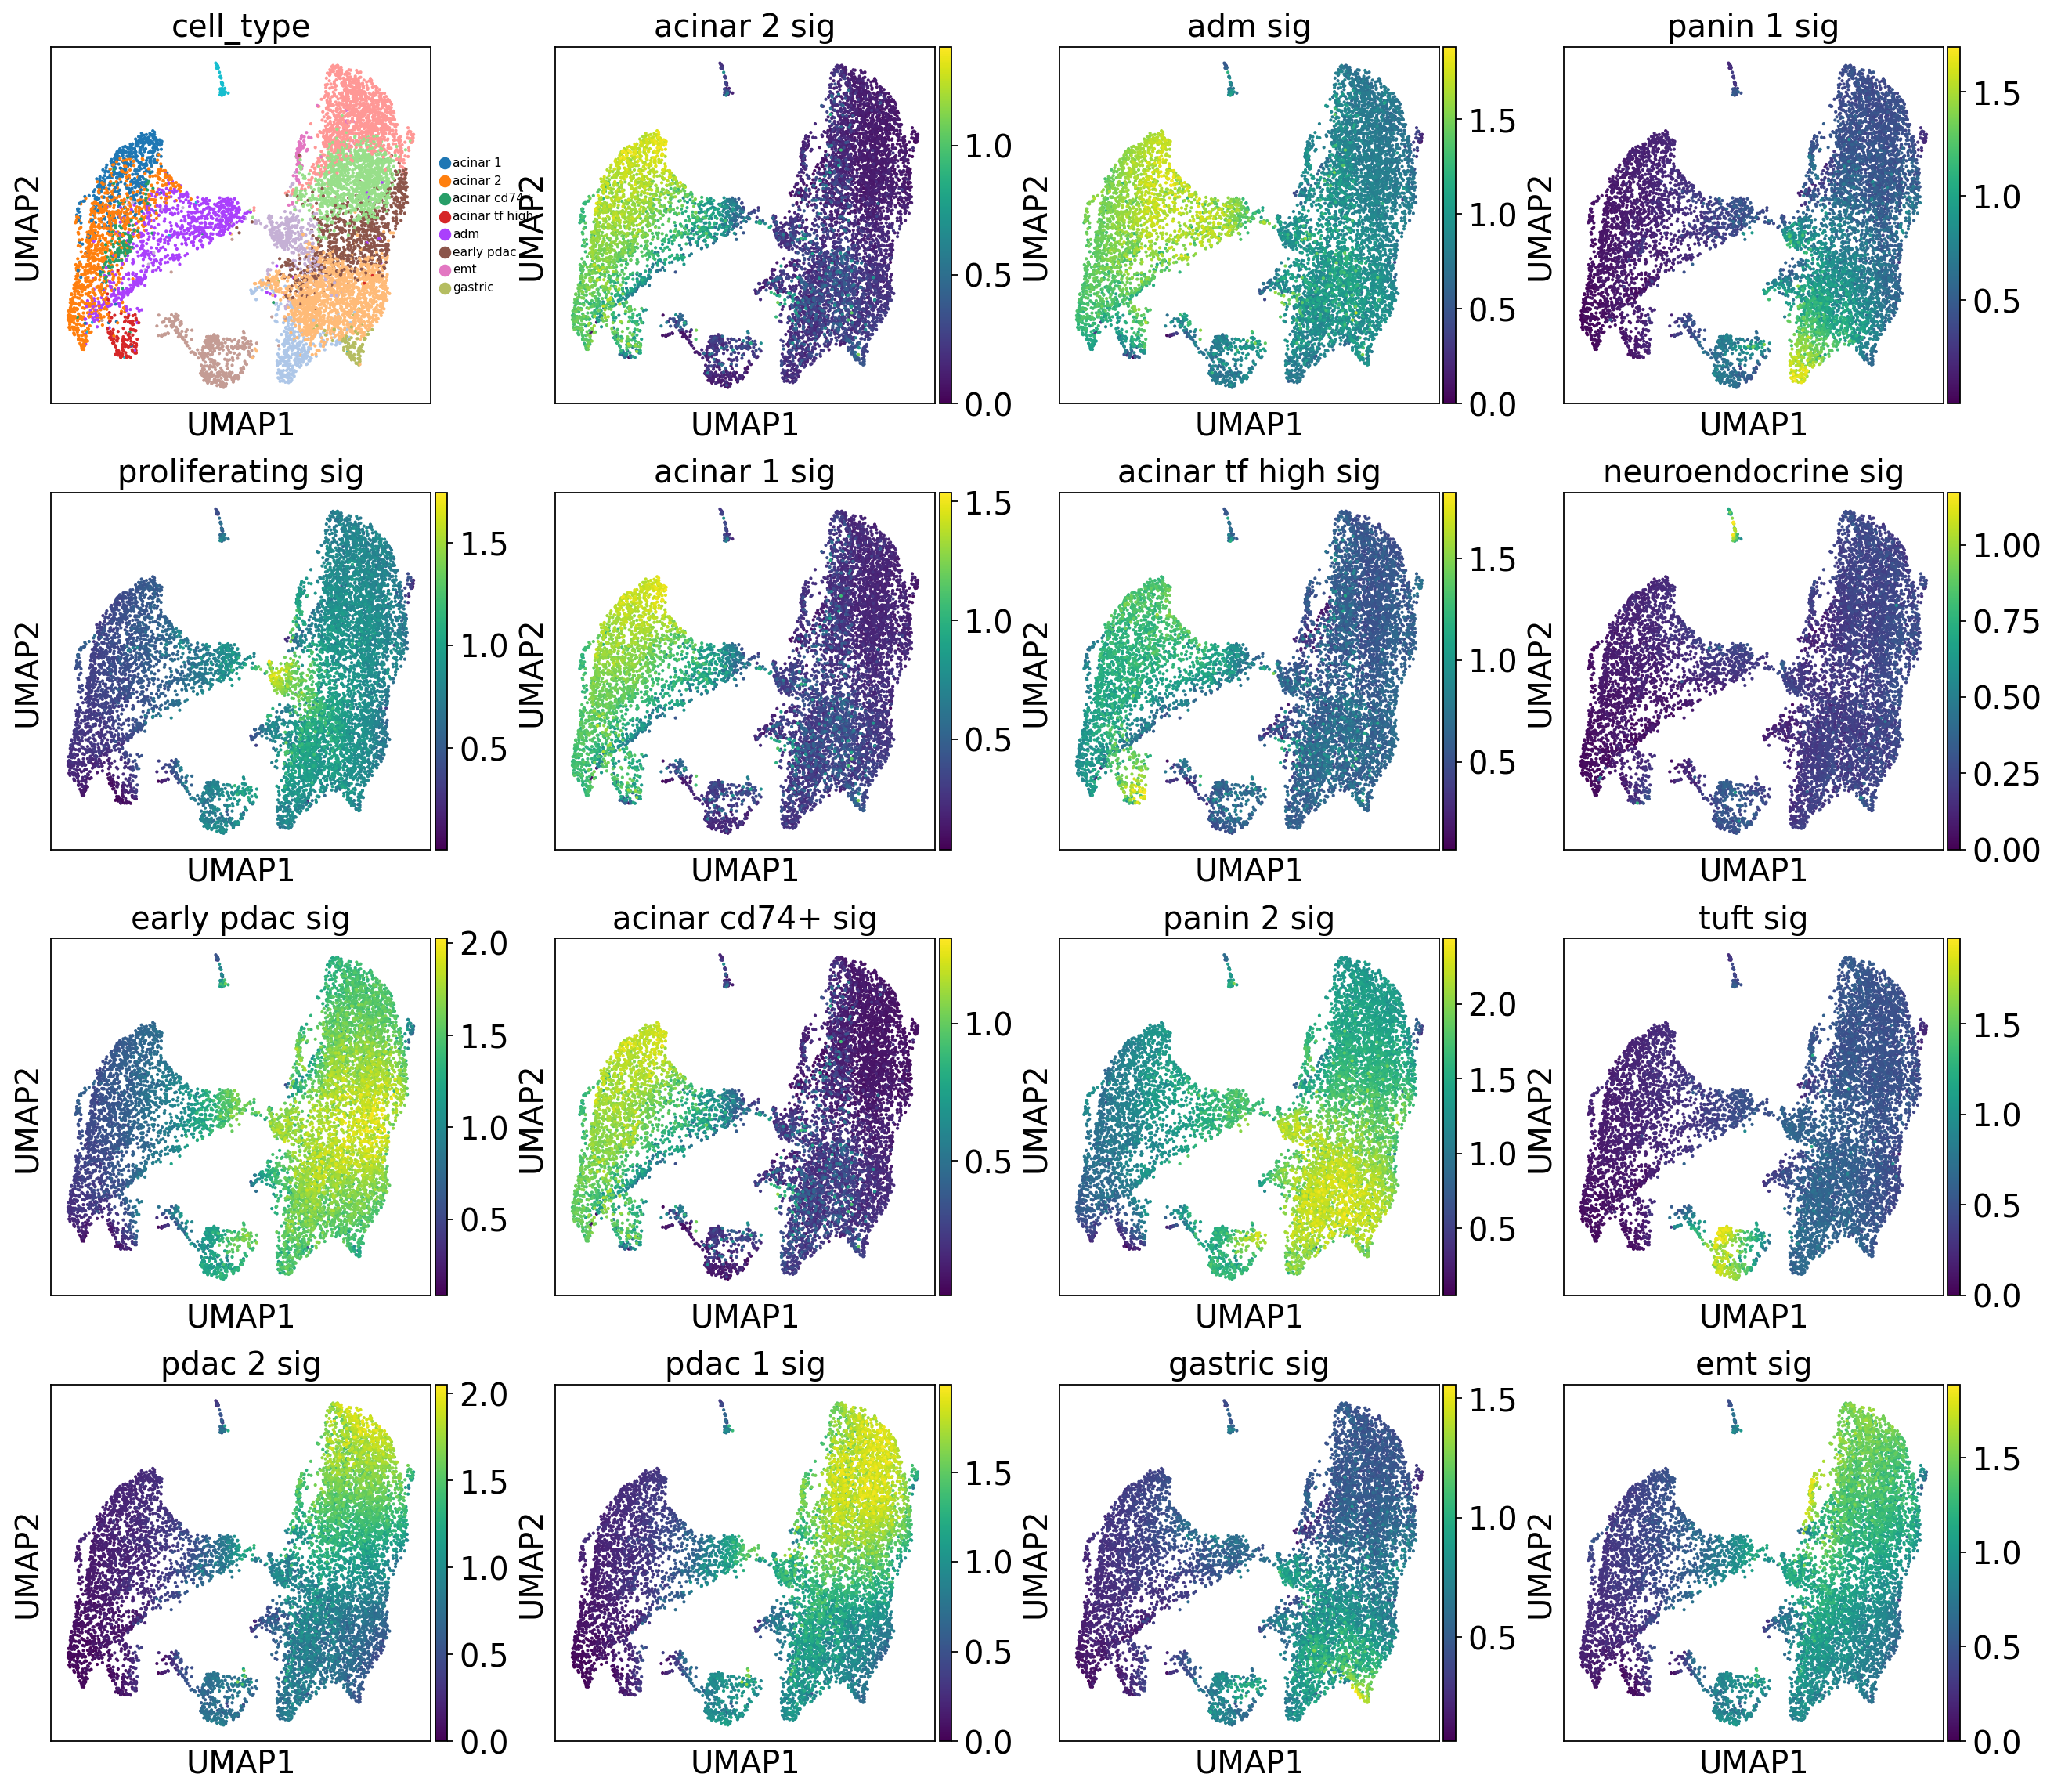

In [8]:
ref_df = adata_ref.to_df()
for cell_type in top_genes_df.columns:
    adata_ref.obs[cell_type + " sig"] = ref_df[top_genes_df[cell_type]].mean(axis=1).values

sc.pp.scale(adata_ref, max_value=10)
sc.tl.pca(adata_ref, svd_solver='arpack')
# Compute the neighborhood graph
sc.pp.neighbors(adata_ref, n_neighbors=20, n_pcs=40)
# Run UMAP
sc.tl.umap(adata_ref)
sc.pl.umap(adata_ref, color=['cell_type'] + [cell_type + " sig" for cell_type in top_genes_df.columns], legend_fontsize=7)

In [9]:
cell_type_genes_df = pd.DataFrame()
for cell_type in meta_ref['cell_type'].unique():
    meta_filter = meta_ref[meta_ref['cell_type'] == cell_type] # 'acinar tf high'
    # Subset the expression matrix to include only the filtered cells
    adata_filter = adata_ref[meta_filter.index].copy().T[rep_genes] # (cells, 750)
    cell_type_genes_df[cell_type] = adata_filter.X.mean(axis=1)

In [10]:
cell_type_genes_df.to_csv('data/cell_type_gene_expressions.csv')
cell_type_genes_df = pd.read_csv('data/cell_type_gene_expressions.csv', index_col=0)
cell_type_genes_df.head()

acinar 2       adm   panin 1  proliferating  acinar 1  acinar tf high  \
0  1.860846  0.617563 -0.513234      -0.435020  1.743202        0.634831   
1  1.831638  0.534392 -0.506251      -0.433858  1.770995        0.982722   
2  1.582990  1.330803 -0.383764      -0.320883  1.387281        0.865262   
3  1.784596  0.487240 -0.397620      -0.411155  1.746855        0.621127   
4  1.761590  0.630799 -0.419069      -0.423691  1.812235        0.697015   

   neuroendocrine  early pdac  acinar cd74+   panin 2      tuft    pdac 2  \
0       -0.423099   -0.575834      1.373841 -0.540874 -0.466303 -0.594816   
1       -0.438577   -0.579664      1.735584 -0.531173 -0.493975 -0.601582   
2       -0.530685   -0.621975      1.485993 -0.529645 -0.413436 -0.709585   
3       -0.499047   -0.564135      1.807009 -0.490662 -0.441628 -0.616637   
4       -0.506579   -0.582804      1.735304 -0.523699 -0.433840 -0.634333   

     pdac 1   gastric       emt  
0 -0.591647 -0.544727 -0.558944  
1 -0.598279 -0.530895 -0.594269  
2 -0.679646 -0.624375 -0.599609  
3 -0.593083 -0.542504 -0.552339  
4 -0.617022 -0.554343 -0.593537

In [11]:
# Normalize total counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)
# Logarithmize the data
sc.pp.log1p(adata)

In [12]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
# Perform clustering on the new data if not already clustered
sc.tl.leiden(adata, resolution=1.0)  # Change 'leiden' to your preferred clustering method

In [13]:
cluster_genes_df = pd.DataFrame()
for cluster in adata.obs['leiden'].unique():
    adata_filter = adata[adata.obs['leiden'] == cluster].copy() # 'acinar tf high'
    # print(adata_filter.shape)
    adata_filter = adata_filter.T[rep_genes]
    # Subset the expression matrix to include only the filtered cells
    cluster_genes_df[cluster] = adata_filter.X.mean(axis=1)

In [14]:
cluster_genes_df.columns = pd.to_numeric(cluster_genes_df.columns, errors='coerce')
cluster_genes_df.sort_index(axis=1).to_csv('data/cluster_gene_expressions.csv')
cluster_genes_df = pd.read_csv('data/cluster_gene_expressions.csv', index_col=0)

In [15]:
cluster_genes_df.head()

0         1         2         3         4         5         6  \
0 -0.362671 -0.022404  0.207489  0.426258 -0.694952  0.347251  0.167642   
1 -0.364110 -0.076526  0.004944  0.293733 -0.446672  0.170574  0.032847   
2 -0.337241  0.041695  0.085228  0.377736 -0.756288  0.240503 -0.075339   
3 -0.386683 -0.079112  0.237102  0.492604 -0.569213  0.323708  0.105152   
4 -0.385705 -0.062700  0.030714  0.336470 -0.534702  0.257613  0.070675   

          7         8         9        10        11        12        13  \
0  2.977548 -0.426577  0.010734 -0.287668 -0.408309 -0.212304 -0.704331   
1  3.351126 -0.364122 -0.101561 -0.242408 -0.343012 -0.207226 -0.483715   
2  2.985392 -0.398085  0.135416 -0.213728 -0.385528 -0.152348 -0.733508   
3  3.071384 -0.474921 -0.121981 -0.234289 -0.419741 -0.235713 -0.608439   
4  3.228336 -0.399134 -0.075875 -0.217258 -0.393966 -0.192585 -0.547303   

         14        15        16        17        18        19        20  \
0  0.227384  0.063175 -0.694882 -0.670217 -0.079866  0.104747  0.055581   
1  0.063031  0.018852 -0.479070 -0.418483 -0.157107 -0.007914 -0.197646   
2  0.060745  0.077968 -0.676599 -0.598309 -0.034921  0.024362  0.115299   
3  0.235939  0.124487 -0.655437 -0.466737 -0.179325  0.123619 -0.238184   
4  0.060688  0.016115 -0.552265 -0.408675 -0.132148  0.015702 -0.160167   

         21        22        23        24        25        26        27  \
0 -0.318142 -0.712075 -0.697284 -0.160873 -0.122908  1.168591 -0.678152   
1 -0.258405 -0.521314 -0.493243 -0.247824 -0.235300  0.654453 -0.371235   
2 -0.329469 -0.904464 -0.687856 -0.103888 -0.059805  2.382926 -0.509382   
3 -0.224706 -0.710561 -0.691029 -0.311799 -0.293938  0.752902 -0.456041   
4 -0.269241 -0.623130 -0.594965 -0.200252 -0.258629  1.428562 -0.415086   

         28        29        30        31        32        33        34  \
0 -0.278492 -0.201385 -0.621582 -0.526570 -0.485821 -0.404051  0.009945   
1 -0.260911 -0.251901 -0.395253 -0.419982 -0.378698 -0.336383  0.020671   
2 -0.277027 -0.190144 -0.138312 -0.478141 -0.505952 -0.256054 -0.052954   
3 -0.268277 -0.184287 -0.500343 -0.577016 -0.507514 -0.333985 -0.003651   
4 -0.321385 -0.182357 -0.393829 -0.451053 -0.416999 -0.322479 -0.007697   

         35        36        37        38        39        40  
0 -0.322691 -0.173231  0.367059 -0.057706  0.505087  1.655911  
1 -0.395897 -0.176384  0.329196  0.008082  0.269312  2.380924  
2 -0.276751 -0.253075  0.350281  0.188522  0.365038  1.421767  
3 -0.454409 -0.155786  0.286166 -0.181198  0.393283  1.210946  
4 -0.359221 -0.224318  0.321078 -0.105460  0.111518  1.555366

In [16]:
correlation_matrix = pd.DataFrame(index=cell_type_genes_df.columns, columns=cluster_genes_df.columns)

In [17]:
for col1 in cell_type_genes_df.columns:
    for col2 in cluster_genes_df.columns:
        # Calculate Pearson correlation between two columns
        correlation = cell_type_genes_df[col1].corr(cluster_genes_df[col2])
        # Store the correlation in the matrix
        correlation_matrix.loc[col1, col2] = correlation

# Convert correlation matrix values to numeric
correlation_matrix = correlation_matrix.apply(pd.to_numeric)

In [18]:
correlation_matrix.to_csv('data/correlations.csv')

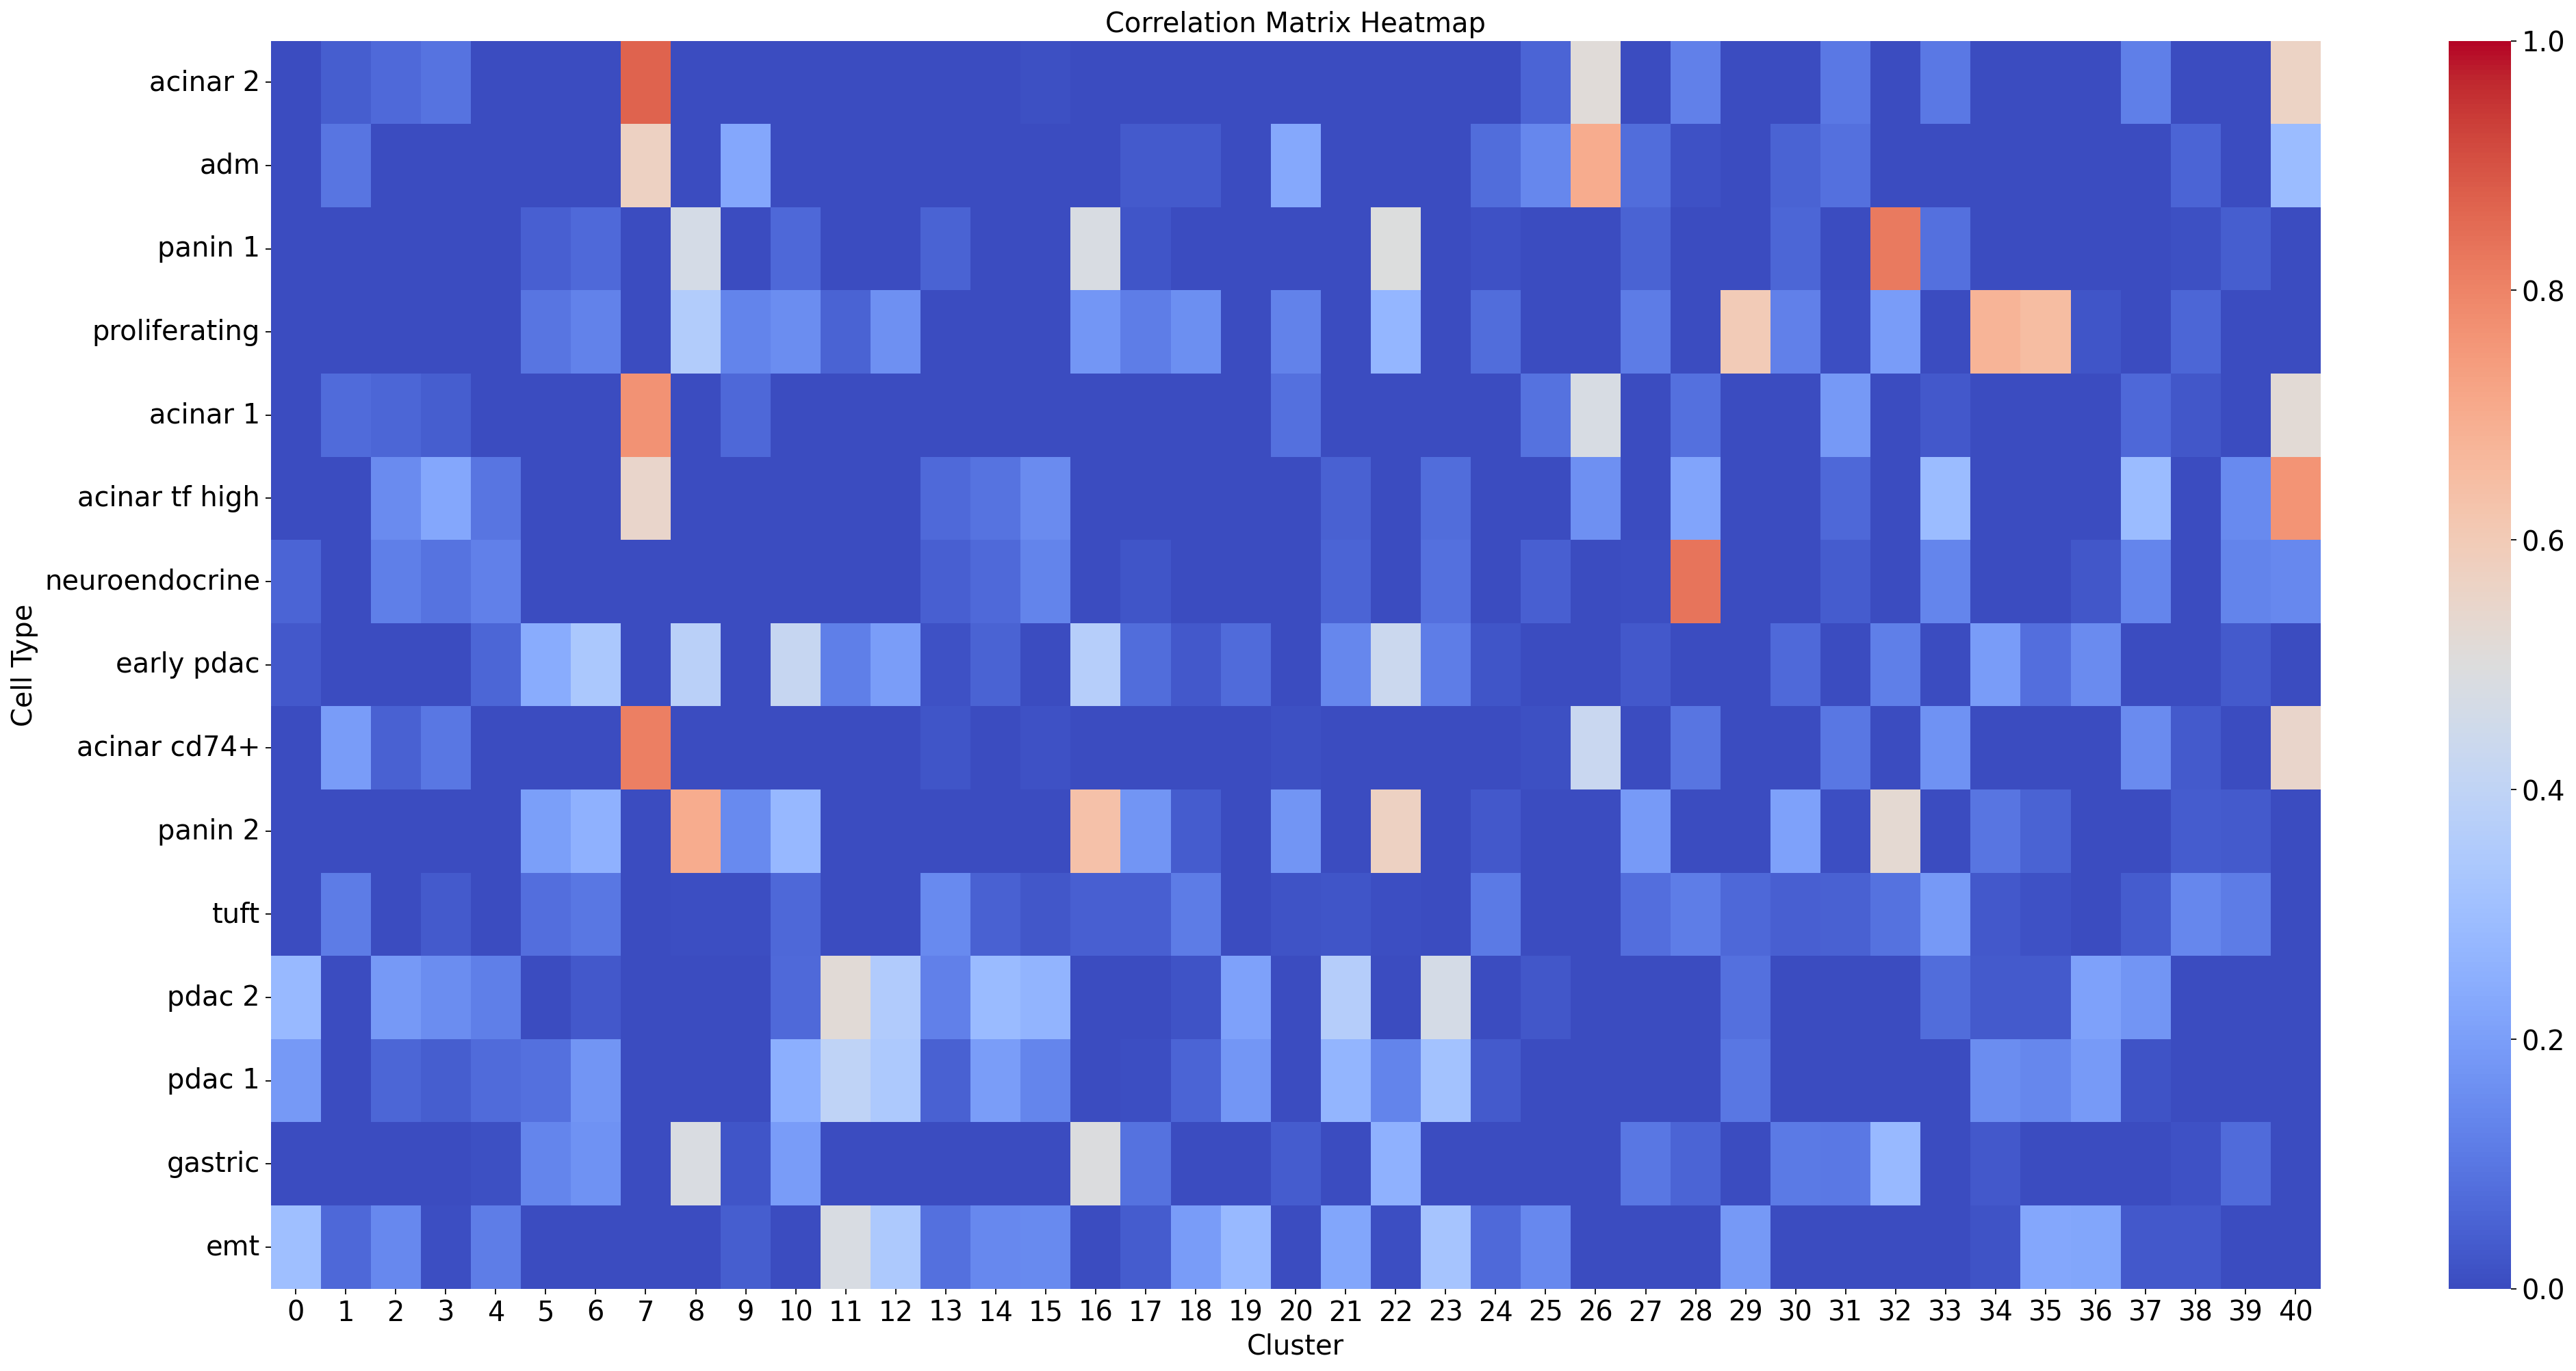

In [19]:
plt.figure(figsize=(30, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmax=1, vmin=0, annot=False, cbar=True)

# Set titles and labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Cluster')
plt.ylabel('Cell Type')

# Display the plot
plt.show()

In [20]:
leiden = adata.obs['leiden']

In [21]:
adata = sc.read_csv("data/GSE141017_ALL.csv", delimiter=None)
barcodes = pd.read_csv('data/GSE141017_ALL_barcode_ident.csv', delimiter='\t')
color_palette = None
adata = adata.T
adata.obs.index = barcodes.index
adata.obs = barcodes
adata.obs['leiden'] = leiden

In [22]:
argmax_df = correlation_matrix.idxmax(axis=0)
argmax_df

0                emt
1       acinar cd74+
2             pdac 2
3     acinar tf high
4     neuroendocrine
5         early pdac
6         early pdac
7           acinar 2
8            panin 2
9                adm
10        early pdac
11            pdac 2
12            pdac 2
13              tuft
14            pdac 2
15            pdac 2
16           panin 2
17           panin 2
18               emt
19               emt
20               adm
21            pdac 2
22           panin 2
23            pdac 2
24              tuft
25               emt
26               adm
27           panin 2
28    neuroendocrine
29     proliferating
30           panin 2
31          acinar 1
32           panin 1
33    acinar tf high
34     proliferating
35     proliferating
36               emt
37    acinar tf high
38              tuft
39    acinar tf high
40    acinar tf high
dtype: object

In [23]:
adata.obs['cell_type'] = adata.obs['leiden'].map(argmax_df)

In [24]:
adata.obs['cell_type']

0                   emt
1                   emt
2                   emt
3                   emt
4                   emt
              ...      
41134    neuroendocrine
41135    neuroendocrine
41136    neuroendocrine
41137    neuroendocrine
41138    neuroendocrine
Name: cell_type, Length: 41139, dtype: object

In [25]:
adata.write_h5ad("data/gse.h5ad")

... storing 'time_point' as categorical
... storing 'cell_type' as categorical
